## Import the Libraries

This makes use of tflearn and tensorflow. Generally speaking, better results were used when using higher level wrappers such as tflearn or slim, so we elected to use those.

In [5]:
import sys
import tensorflow as tf
import tflearn
from tflearn.layers.recurrent import bidirectional_rnn, BasicLSTMCell
from tflearn.layers.core import dropout
from tflearn.layers.conv import conv_2d, max_pool_2d
from audio_dataset_generator import AudioDatasetGenerator
import numpy as np
import IPython.display as ipd

## Model and Program Parameters

Set the appropriate settings for the model here. Audio data path will choose which folder to get fft frames from. Make sure the files are .wav and they are the only files you want as all the files fft frames are loaded and concatenated together. 

Please note:
* ```rnn_type``` should equal any of the following values: lstm, gru, bi_lstm, bi_gru
* ```number_rnn_layers``` should be greater than 0
* ```activation``` should be the string defined in the tflearn library for [any of the activations defined here](http://tflearn.org/activations/)

In [6]:
# Dataset
sequence_length      = 48
audio_data_path      = "assets/test_samples"
force_new_dataset    = True

# Feature Extraction and Audio Genreation
sample_rate          = 11025
fft_settings         = [1024, None, None]
fft_size             = fft_settings[0]
window_size          = fft_settings[1]
hop_size             = fft_settings[2]

# General Network
learning_rate        = 0.0004
amount_epochs        = 1200
batch_size           = 32
dropout              = 0.0
loss_type            = "mean_square"
activation           = 'elu'
optimiser            = 'adam'
fully_connected_dim  = int(fft_size / 2 + 1)

# Recurrent Neural Network
rnn_type             = "lstm"
number_rnn_layers    = 4
rnn_number_units     = 128

# Convolutional Neural Network
use_cnn              = False
number_filters       = [32, 64]
filter_sizes         = [3, 3]

## Create or Load the Dataset

Take the fft magnitudes from the folder specified at the audio_data_path and create the magnitudes.

In [7]:
dataset = AudioDatasetGenerator(fft_size, window_size, hop_size,
                                sequence_length, sample_rate)

dataset.load(audio_data_path, force_new_dataset)

if use_cnn:
    dataset.x_frames = dataset.x_frames.reshape(dataset.x_frames.shape[0], 
                                                dataset.x_frames.shape[1], 
                                                dataset.x_frames.shape[2], 1)

100% data generation complete.  

## Create the Model

A couple of helper methods are defined to speed up the process of experimenting with the model's archetecture.

In [8]:
def conv_net(net, filters, kernels, non_linearity):  
    """
    A quick function to build a conv net. 
    At the end it reshapes the network to be 3d to work with recurrent units.
    """
    assert len(filters) == len(kernels)
    
    for i in range(len(filters)):
        net = conv_2d(net, filters[i], kernels[i], activation=non_linearity)
        net = max_pool_2d(net, 2)
        
    dim1 = net.get_shape().as_list()[1]
    dim2 = net.get_shape().as_list()[2]
    dim3 = net.get_shape().as_list()[3]
    return tf.reshape(net, [-1, dim1 * dim3, dim2])
   
                      
def recurrent_net(net, rec_type, rec_size, return_sequence):
    """
    A quick if else block to build a recurrent layer, based on the type specified
    by the user.
    """
    if rec_type == 'lstm':
        net = tflearn.layers.recurrent.lstm(net, rec_size, return_seq=return_sequence)
    elif rec_type == 'gru':
        net = tflearn.layers.recurrent.gru(net, rec_size, return_seq=return_sequence)
    elif rec_type == 'bi_lstm':
        net = bidirectional_rnn(net, 
                                BasicLSTMCell(rec_size), 
                                BasicLSTMCell(rec_size), 
                                return_seq=return_sequence)
    elif rec_type == 'bi_gru':
        net = bidirectional_rnn(net, 
                                GRUCell(rec_size), 
                                GRUCell(rec_size), 
                                return_seq=return_sequence)
    else:
        raise ValueError('Incorrect rnn type passed. Try lstm, gru, bi_lstm or bi_gru.')
    return net

Next the actual structure of the net is specified.

If use_cnn is true the model will be prefixed with a cnn. This will slow things down but produces a different kind of result. The model regardless then builds a rnn layer which runs into a fully connected layer. before being passed to linear outputs.

In [9]:
if use_cnn:
    net = tflearn.input_data([None, 
                              dataset.x_frames.shape[1], 
                              dataset.x_frames.shape[2], 
                              dataset.x_frames.shape[3]])
    net = conv_net(net, number_filters, filter_sizes, activation)
else:                  
    net = tflearn.input_data([None, 
                              dataset.x_frames.shape[1], 
                              dataset.x_frames.shape[2]]) 

for layer in range(number_rnn_layers):
    return_sequence = False if layer == (number_rnn_layers - 1) else True
    net = recurrent_net(net, rnn_type, rnn_number_units, return_sequence)
    net = dropout(net, dropout) if dropout > 0.0 else net
    
net = tflearn.fully_connected(net, fully_connected_dim, 
                              activation=activation,                                            
                              regularizer='L2', 
                              weight_decay=0.001)
                      
net = tflearn.fully_connected(net, dataset.y_frames.shape[1], 
                              activation='linear')
                      
net = tflearn.regression(net, optimizer=optimiser, learning_rate=learning_rate,                                 
                         loss=loss_type)

model = tflearn.DNN(net)

## Train the Model

Currently we aren't worried about overfitting, so we just pass the entire dataset of generated magnitudes. Perhaps we might want to change this, in which case we would need to split the dataset into training, validation and testing subsets.

In [10]:
model.fit(dataset.x_frames, dataset.y_frames, show_metric=True, 
          batch_size=batch_size, n_epoch=amount_epochs)

Training Step: 290399  | total loss: 0.12698 | time: 21.610s
| Adam | epoch: 1200 | loss: 0.12698 - acc: 0.9158 -- iter: 7712/7723
Training Step: 290400  | total loss: 0.13020 | time: 21.709s
| Adam | epoch: 1200 | loss: 0.13020 - acc: 0.9180 -- iter: 7723/7723
--


In [11]:
from email_notification import EmailNotification
notifications_on = True
email_address = 'wprim001@gold.ac.uk'
email = EmailNotification(email_address)

## Generating Audio

Here we generate audio. Choose the amount of samples, then how long they should be with sequence length, and then how many iterations the griffin lim algorithm should run for. The impluse scale is something we haven't objectively tested yet, but it just scales the initial magnitudes for the models first predictions. 

Depending on whether there are convolutions in the network will mean we will need to reshape appropriately. Also note that the audio generated is saved in the audio variable as a 2d numpy array.

In [12]:
amount_samples      = 8
sequence_length_max = 1400
impulse_scale       = 0.1
griffin_iterations  = 100

dimension1 = dataset.x_frames.shape[1]
dimension2 = dataset.x_frames.shape[2]
shape = (1, dimension1, dimension2, 1) if use_cnn else (1, dimension1, dimension2)

audio = []
for i in range(amount_samples):                                                                                                                                   
    
    random_index = np.random.randint(0, (len(dataset.x_frames) - 1))                                                                                                                    
                                                                                                                                                                              
    impulse = np.array(dataset.x_frames[random_index]) * impulse_scale
    predicted_magnitudes = impulse
    
    for j in range(sequence_length_max):

        prediction = model.predict(impulse.reshape(shape))
        
        if use_cnn:
            prediction = prediction.reshape(1, dataset.y_frames.shape[1], 1)
            
        predicted_magnitudes = np.vstack((predicted_magnitudes, prediction))                                                                                                  
        impulse = predicted_magnitudes[-sequence_length:]
        
        done = int(float(i * sequence_length_max + j) / float(amount_samples * sequence_length_max) * 100.0) + 1
        sys.stdout.write('{}% audio generation complete.   \r'.format(done))
        sys.stdout.flush()
        
        if done == 100 and notifications_on:
            email.send()
            notifications_on = False
                                                                                                                                                                              
    predicted_magnitudes = np.array(predicted_magnitudes).reshape(-1, 513)                                                                           
    audio += [dataset.griffin_lim(predicted_magnitudes.T, griffin_iterations)]

audio = np.array(audio)

email sent generation complete.   


## Testing and Plotting the Results

Select the index you want to listen to. It may be useful to plot stuff below too using matplotlib.

In [30]:
from IPython.display import Audio

i = 4
Audio(audio[i], rate=sample_rate)

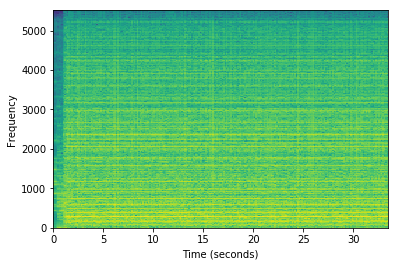

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.specgram(audio[i], NFFT=2048, Fs=sample_rate, noverlap=512)

# Plot a spectrogram
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

In [15]:
testaudio = dataset.griffin_lim(dataset.x_frames[100].T)
Audio(testaudio, rate=sample_rate)

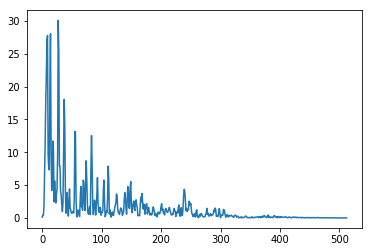

In [16]:
plt.plot(dataset.x_frames[5][15])

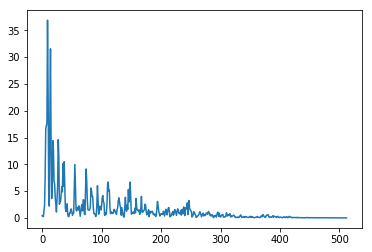

In [17]:
plt.plot(dataset.y_frames[5])